# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет, на основе предоставленных исторических данных о поведении клиентов и расторжении договоров с банком. 

Задача - построить модель с предельно большим значением *F1*-меры.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import shuffle

In [1]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Подгрузили библиотеки, открыли файл: всего в таблице 10 тыс объектов и 14 признаков.

In [2]:
df.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [3]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Пропуски содержатся в признаке "Количество недвижимости у клиента", заполним их медианным значением и далее построим график важности признаков, так как есть подозрение, что признак не значим.

In [4]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Убрали признаки, которые нам не понадобятся в анализе и являются порядковыми: номер строки, индентификационный номер пользователя, и фамилия.

In [5]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,-0.000060,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.012606,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.000060,-0.012606,1.000000,-0.007535,0.011409,0.025979,-0.030681,0.010049,-0.015989
Balance,0.006268,0.028308,-0.007535,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.025979,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.030681,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.010049,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.015989,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


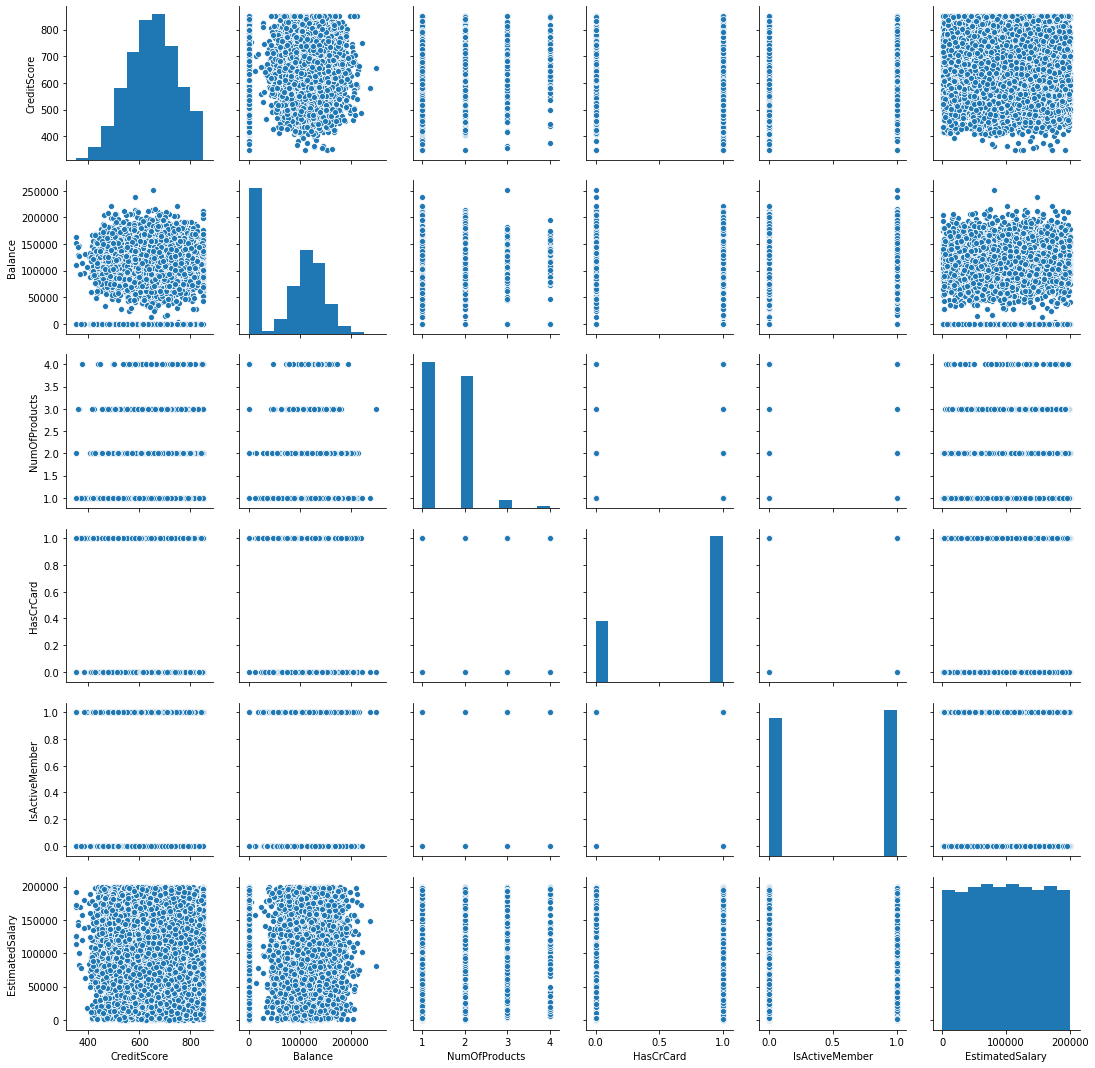

In [6]:
cols = ['CreditScore', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
a = sns.pairplot(df[cols])

Проверили на мультиколлинеарность и также графически оценили связь: признаки мало коррелируют между собой, поэтому все их оставляем.

In [7]:
df_ohe = pd.get_dummies(df, drop_first=True)
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

Преобразовали категориальные признаки техникой прямого кодирования и сразу же убрали лишние столбцы.

In [8]:
features_train, features_2, target_train, target_2 = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_2, target_2, test_size=0.5, random_state=12345)

Разделили выборку на 3: тренировочную, валидационную и тестовую.

In [9]:
numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard',
           'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


Масштабировали количественные признаки всех выборок методом стандартизации данных и проверили размеры новых выборок. 

# 2. Исследование задачи

Исследуем баланс классов и обучим модель без учёта дисбаланса.

In [10]:
target_train.value_counts(normalize=True)

0    0.800667
1    0.199333
Name: Exited, dtype: float64

В выборке клиенты, покинувших банк, составляют примерно 1/5 от общего количества клиентов, то есть почти в 4 раза меньше оставшихся клиентов.

In [11]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_train, target_train)
predictions = model.predict(features_valid)
probs = model.predict_proba(features_valid)
probs_one = probs[:, 1]

print('f1_score: {:.3f}'.format(f1_score(target_valid, predictions)))
print('roc_auc: {:.3f}'. format(roc_auc_score(target_valid, probs_one)))
print('precision: {:.3f}'.format(precision_score(target_valid, predictions)))
print('recall: {:.3f}'.format(recall_score(target_valid, predictions)))

f1_score: 0.331
roc_auc: 0.759
precision: 0.563
recall: 0.234


Обучили модель логистической регрессии без учета дисбаланса и получили следующие данные:
- f1 score 0.32 не высокое значение
- accuracy 0.8 тут дело обстоит получше

In [12]:
%%time

for i in range(1, 30, 3):
    for j in range(1, 50 , 5):
        model = RandomForestClassifier(random_state=12345, n_estimators=i, max_depth=j)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        probs = model.predict_proba(features_valid)
        probs_one = probs[:, 1]
        print('n_estimators', i, 'max_depth', j)
        print('f1_score: {:.3f}'.format(f1_score(target_valid, predictions)))
        print('roc_auc: {:.3f}'. format(roc_auc_score(target_valid, probs_one)))
        print('precision: {:.3f}'.format(precision_score(target_valid, predictions)))
        print('recall: {:.3f}'.format(recall_score(target_valid, predictions)))
        print(' ')

n_estimators 1 max_depth 1
f1_score: 0.248
roc_auc: 0.569
precision: 0.836
recall: 0.146
 
n_estimators 1 max_depth 6
f1_score: 0.424
roc_auc: 0.780
precision: 0.791
recall: 0.289
 
n_estimators 1 max_depth 11
f1_score: 0.524
roc_auc: 0.726
precision: 0.567
recall: 0.488
 
n_estimators 1 max_depth 16
f1_score: 0.507
roc_auc: 0.695
precision: 0.473
recall: 0.545
 
n_estimators 1 max_depth 21
f1_score: 0.494
roc_auc: 0.684
precision: 0.464
recall: 0.529
 
n_estimators 1 max_depth 26
f1_score: 0.494
roc_auc: 0.684
precision: 0.464
recall: 0.529
 
n_estimators 1 max_depth 31
f1_score: 0.494
roc_auc: 0.684
precision: 0.464
recall: 0.529
 
n_estimators 1 max_depth 36
f1_score: 0.494
roc_auc: 0.684
precision: 0.464
recall: 0.529
 
n_estimators 1 max_depth 41
f1_score: 0.494
roc_auc: 0.684
precision: 0.464
recall: 0.529
 
n_estimators 1 max_depth 46
f1_score: 0.494
roc_auc: 0.684
precision: 0.464
recall: 0.529
 
n_estimators 4 max_depth 1
f1_score: 0.000
roc_auc: 0.776
precision: 0.000
recall:

Наилучшего результата f1 score получается добиться при нескольких наборах гиперпараметров: 
- n_estimators 7 max_depth 11
- n_estimators 16 max_depth 16

In [14]:
model = RandomForestClassifier(random_state=12345, n_estimators=7, max_depth=11)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)                               
print('f1_score: {:.3f}'.format(f1_score(target_valid, predictions)))
print('roc_auc: {:.3f}'. format(roc_auc_score(target_valid, probs_one)))
print('precision: {:.3f}'.format(precision_score(target_valid, predictions)))
print('recall: {:.3f}'.format(recall_score(target_valid, predictions)))

f1_score: 0.587
roc_auc: 0.833
precision: 0.748
recall: 0.483


Вывели результат модели с лучшими гиперпараметрами.

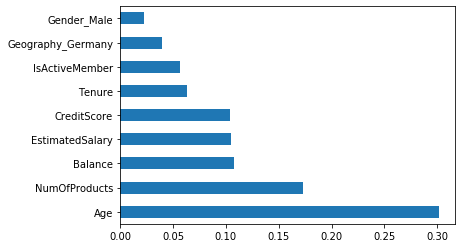

In [64]:
feat_importances = pd.Series(model.feature_importances_, index=features_train.columns)
z = feat_importances.nlargest(9).plot(kind='barh')

На основе лучше модели построили график важности признаков: 
- самый важный признак (0.24) — Возраст
- далее почти одинаково важны (0.13 - 0.15): Предполагаемая зарплата, Кредитный рейтинг, Баланс на счёте и Количество продуктов банка, используемых клиентом
- менее важны (0.7 и ниже): Количество недвижимости у клиента, Активность клиента, Страна проживания и Пол

# 3. Борьба с дисбалансом

In [56]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeroes = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeroes] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_train.shape)
target_train.value_counts()

(6000, 11)


0    4804
1    1196
Name: Exited, dtype: int64

Провели апсемлинг и "увеличили" количество наблюдений с классом 1.

In [57]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_valid)
probs = model.predict_proba(features_valid)
probs_one = probs[:, 1]
print('f1_score: {:.3f}'.format(f1_score(target_valid, predictions)))
print('roc_auc: {:.3f}'. format(roc_auc_score(target_valid, probs_one)))
print('precision: {:.3f}'.format(precision_score(target_valid, predictions)))
print('recall: {:.3f}'.format(recall_score(target_valid, predictions)))

f1_score: 0.585
roc_auc: 0.809
precision: 0.670
recall: 0.519


Увеличение выборки не привело к улучшению результатов: 
- f1 score 0.56 не изменился
- roc auc и precision немного уменьшились

In [58]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Теперь попробуем наоборот уменьшить наблюдения с классом 0.

In [59]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predictions = model.predict(features_valid)
probs = model.predict_proba(features_valid)
probs_one = probs[:, 1]
print('f1_score: {:.3f}'.format(f1_score(target_valid, predictions)))
print('roc_auc: {:.3f}'. format(roc_auc_score(target_valid, probs_one)))
print('precision: {:.3f}'.format(precision_score(target_valid, predictions)))
print('recall: {:.3f}'.format(recall_score(target_valid, predictions)))

f1_score: 0.572
roc_auc: 0.831
precision: 0.483
recall: 0.701


Уменьшение выборки также в целом не улучшило результаты:
- f1 score хоть и увеличился до 0.57
- precision при этом упал до 0.48

In [65]:
%%time

for i in range(1, 50, 5):
    for j in range(1, 50 , 5):
        model = RandomForestClassifier(random_state=12345, n_estimators=i, max_depth=j, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        probs = model.predict_proba(features_valid)
        probs_one = probs[:, 1]
        print('n_estimators', i, 'max_depth', j)
        print('f1_score: {:.3f}'.format(f1_score(target_valid, predictions)))
        print('roc_auc: {:.3f}'. format(roc_auc_score(target_valid, probs_one)))
        print('precision: {:.3f}'.format(precision_score(target_valid, predictions)))
        print('recall: {:.3f}'.format(recall_score(target_valid, predictions)))
        print(' ')

n_estimators 1 max_depth 1
f1_score: 0.248
roc_auc: 0.569
precision: 0.836
recall: 0.146
 
n_estimators 1 max_depth 6
f1_score: 0.533
roc_auc: 0.797
precision: 0.430
recall: 0.701
 
n_estimators 1 max_depth 11
f1_score: 0.516
roc_auc: 0.749
precision: 0.431
recall: 0.644
 
n_estimators 1 max_depth 16
f1_score: 0.493
roc_auc: 0.683
precision: 0.476
recall: 0.512
 
n_estimators 1 max_depth 21
f1_score: 0.492
roc_auc: 0.679
precision: 0.489
recall: 0.495
 
n_estimators 1 max_depth 26
f1_score: 0.492
roc_auc: 0.679
precision: 0.489
recall: 0.495
 
n_estimators 1 max_depth 31
f1_score: 0.492
roc_auc: 0.679
precision: 0.489
recall: 0.495
 
n_estimators 1 max_depth 36
f1_score: 0.492
roc_auc: 0.679
precision: 0.489
recall: 0.495
 
n_estimators 1 max_depth 41
f1_score: 0.492
roc_auc: 0.679
precision: 0.489
recall: 0.495
 
n_estimators 1 max_depth 46
f1_score: 0.492
roc_auc: 0.679
precision: 0.489
recall: 0.495
 
n_estimators 6 max_depth 1
f1_score: 0.556
roc_auc: 0.776
precision: 0.492
recall:

Наилучшего результата удалось достичь при настройке гиперпараметра вес классов сбалансированный - удалось достичь максимального f1 score 0.61 в нескольких случаях:
- n_estimators 6 max_depth 6
- n_estimators 11 max_depth 6
- n_estimators 16 max_depth 6
- n_estimators 16 max_depth 11

# 4. Тестирование модели

In [67]:
features_combined = pd.concat([features_train] + [features_valid])
target_combined = pd.concat([target_train] + [target_valid])

In [70]:
model = RandomForestClassifier(random_state=12345, n_estimators=16, max_depth=11, class_weight='balanced')
model.fit(features_combined, target_combined)
predictions = model.predict(features_test)
probs = model.predict_proba(features_test)
probs_one = probs[:, 1]
print('f1_score: {:.3f}'.format(f1_score(target_test, predictions)))
print('roc_auc: {:.3f}'. format(roc_auc_score(target_test, probs_one)))
print('precision: {:.3f}'.format(precision_score(target_test, predictions)))
print('recall: {:.3f}'.format(recall_score(target_test, predictions)))

f1_score: 0.597
roc_auc: 0.850
precision: 0.606
recall: 0.589


Для более точного результата обобщили выборку обучающую и валидационную. Тестирование доказало, что модель параметры настроены верно, на тестовой выборке лучше подошли n_estimators 16, max_depth 11: удалось добавиться f1-меры 0,59 и roc-auc 0,85.